# Notebook de treinamento de redes convolucionais com os dados classificados por especialistas

Neste notebook treinamos diversas arquiteturas de redes convolucionais partindo dos pesos da ImageNet. Para este notebook, usamos apenas os dados anotados por especialistas e avaliamos as redes no conjunto de validação.

# Base de dados e importações

In [ ]:

!gdown --id 1GjA8kSfsJYRQPtOedhKq1ISig_99vpc7 --output dados.zip
!unzip dados.zip
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

Downloading...
From: https://drive.google.com/uc?id=1GjA8kSfsJYRQPtOedhKq1ISig_99vpc7
To: /content/dados.zip
36.6MB [00:00, 171MB/s]
Archive:  dados.zip
replace content/audios_MFCC_trim40_especialistas/350e8396-e67e-491a-89dd-666702548d63.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Downloading...
From: https://drive.google.com/uc?id=1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_
To: /content/CSV.zip
100% 1.32M/1.32M [00:00<00:00, 89.1MB/s]
Archive:  CSV.zip
replace CSV/original.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.jpg'
val['uuid'] = val['uuid'] + '.jpg'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.3982300884955752
*   symptomatic -  represenatado pelo 1 - ficou com o peso 1.0 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 1.5906040268456376

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.3982300884955752, 1: 1.0, 2: 1.5906040268456376}

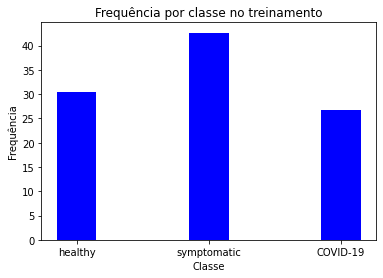

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-especialista.png')

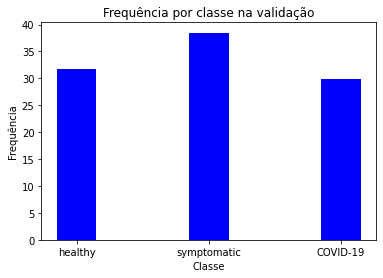

In [ ]:
plt.bar(0, len(val.values[val.classInt.values == 0])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(1, len(val.values[val.classInt.values == 1])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(2, len(val.values[val.classInt.values == 2])/len(val.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe na validação')
plt.savefig('Validacao.png')

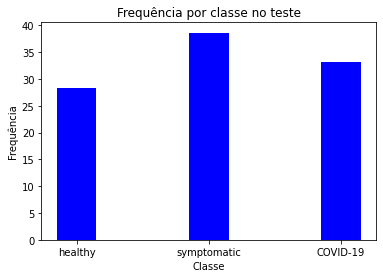

In [ ]:
teste = pd.read_csv('/content/CSV/test.csv')
teste['classInt'] = teste['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
plt.bar(0, len(teste.values[teste.classInt.values == 0])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(1, len(teste.values[teste.classInt.values == 1])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(2, len(teste.values[teste.classInt.values == 2])/len(teste.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no teste')
plt.savefig('Teste.png')

# Função para treinamento de modelos

Como foi analisado que a execução de uma época da rede dura poucos segundos iremos testar a base com esse pré-processamento em 21 redes diferentes da imagenet para ver qual obteve a melhor acurácia tornando-a por fim o nosso baseline inicial. As redes a serem analisadas são listadas abaixo:

ResNet50
ResNet101	
ResNet152	
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5	
EfficientNetB6	
EfficientNetB7	
MobileNet	
MobileNetV2	
DenseNet121	
DenseNet169	
DenseNet201	
InceptionV3	
InceptionResNetV2	
Xception	
VGG16	
VGG19	

In [ ]:
def cria_e_treina_rede(model_name, train_df, val_df, batch_size=32, callbacks=[], image_size=(256, 256), pooling='avg', loss='categorical_crossentropy', epochs=500, class_weights=class_weights, trainable=True):

  if model_name == 'resnet50' or model_name == 'resnet101' or model_name == 'resnet152':
    preprocessing_function = tf.keras.applications.resnet.preprocess_input
  elif model_name == 'efficientnetb0' or model_name == 'efficientnetb1' or model_name == 'efficientnetb2' or model_name == 'efficientnetb3' or model_name == 'efficientnetb4' or model_name == 'efficientnetb5'  or model_name == 'efficientnetb6' or model_name == 'efficientnetb7':
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
  elif model_name == 'mobilenet':
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
  elif model_name == 'mobilenetv2':
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
  elif model_name == 'densenet121' or model_name == 'densenet169' or model_name == 'densenet201':
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
  elif model_name == 'inceptionv3':
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
  elif model_name == 'inceptionresnetv2':
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input
  elif model_name == 'xception':
    preprocessing_function = tf.keras.applications.xception.preprocess_input
  elif model_name == 'vgg16':
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
  elif model_name == 'vgg19':
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_function,
  )

  train_generator = datagen.flow_from_dataframe(
    train_df, directory='/content/content/audios_MFCC_trim40_especialistas', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42, color_mode='rgb')

  val_generator = datagen.flow_from_dataframe(
    val_df, directory='/content/content/audios_MFCC_trim40_especialistas', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=False, seed=42, color_mode='rgb')
  
  if model_name == 'resnet50':
    pre_trained = tf.keras.applications.ResNet50(include_top=False, pooling=pooling)
  elif model_name == 'resnet101':
    pre_trained = tf.keras.applications.ResNet101(include_top=False, pooling=pooling)
  elif model_name == 'resnet152':
    pre_trained = tf.keras.applications.ResNet152(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb0':
    pre_trained = tf.keras.applications.EfficientNetB0(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb1':
    pre_trained = tf.keras.applications.EfficientNetB1(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb2':
    pre_trained = tf.keras.applications.EfficientNetB2(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb3':
    pre_trained = tf.keras.applications.EfficientNetB3(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb4':
    pre_trained = tf.keras.applications.EfficientNetB4(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb5':
    pre_trained = tf.keras.applications.EfficientNetB5(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb6':
    pre_trained = tf.keras.applications.EfficientNetB6(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb7':
    pre_trained = tf.keras.applications.EfficientNetB7(include_top=False, pooling=pooling)
  elif model_name == 'mobilenet':
    pre_trained = tf.keras.applications.MobileNet(include_top=False, pooling=pooling)
  elif model_name == 'mobilenetv2':
    pre_trained = tf.keras.applications.MobileNetV2(include_top=False, pooling=pooling)
  elif model_name == 'densenet121':
    pre_trained = tf.keras.applications.DenseNet121(include_top=False, pooling=pooling)
  elif model_name == 'densenet169':
    pre_trained = tf.keras.applications.DenseNet169(include_top=False, pooling=pooling)
  elif model_name == 'densenet201':
    pre_trained = tf.keras.applications.DenseNet201(include_top=False, pooling=pooling)
  elif model_name == 'inceptionv3':
    pre_trained = tf.keras.applications.InceptionV3(include_top=False, pooling=pooling)
  elif model_name == 'inceptionresnetv2':
    pre_trained = tf.keras.applications.InceptionResNetV2(include_top=False, pooling=pooling)
  elif model_name == 'xception':
    pre_trained = tf.keras.applications.Xception(include_top=False, pooling=pooling)
  elif model_name == 'vgg16':
    pre_trained = tf.keras.applications.VGG16(include_top=False, pooling=pooling)
  elif model_name == 'vgg19':
    pre_trained = tf.keras.applications.VGG19(include_top=False, pooling=pooling)

  for layer in pre_trained.layers:
    layer.treinable = trainable

  model = tf.keras.models.Sequential([
   pre_trained,
   tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.summary()

  optimizer = tf.keras.optimizers.Adam(0.000001)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/' + model_name + '.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(model_name + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_df): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelos

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
35/35 [==============================] - 33s 310ms/step - loss: 1.6108 - acc: 0.3105 - val_loss: 1.3436 - val_acc: 0.3022
Epoch 2/500
35/35 [========================

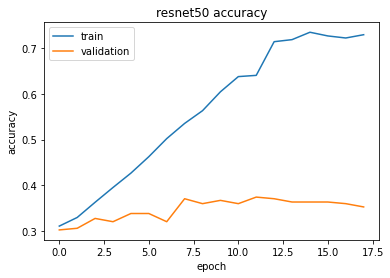

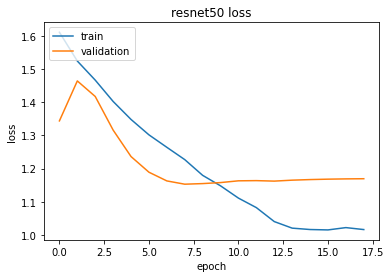

9/9 [==============================] - 2s 89ms/step
[[49 28 11]
 [46 39 22]
 [44 24 15]]
Acuracia balanceada na validacao: 0.367342351564286


In [ ]:
cria_e_treina_rede('resnet50', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
171450368/171446536 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 42,558,979
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 29s 461ms/step - loss: 1.5543 - acc: 0.4203 - val_loss: 1.5842 - val_acc: 0.3705
Epoch 2/500
35/35 [==============================] - 14s 392ms/step - loss: 1.4583 - acc: 0.4383 - val_loss: 1.4953 - val_acc: 0.3849
Epoch 3/500
35/35 [=======================

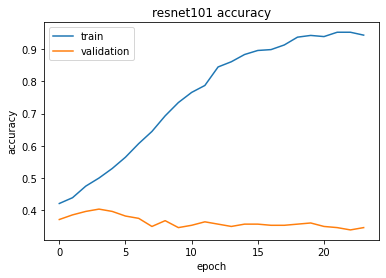

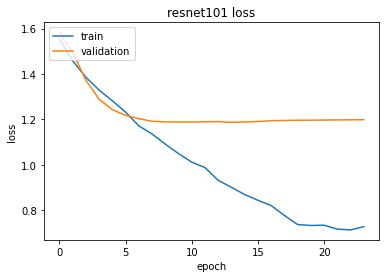

9/9 [==============================] - 3s 115ms/step
[[23 34 31]
 [31 49 27]
 [24 34 25]]
Acuracia balanceada na validacao: 0.3401707936247966


In [ ]:
cria_e_treina_rede('resnet101', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
234700800/234698864 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 58,377,091
Trainable params: 58,225,667
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 43s 658ms/step - loss: 1.9441 - acc: 0.3573 - val_loss: 1.8648 - val_acc: 0.3058
Epoch 2/500
35/35 [==============================] - 20s 557ms/step - loss: 1.8063 - acc: 0.3780 - val_loss: 1.5918 - val_acc: 0.3022
Epoch 3/500
35/35 [=======================

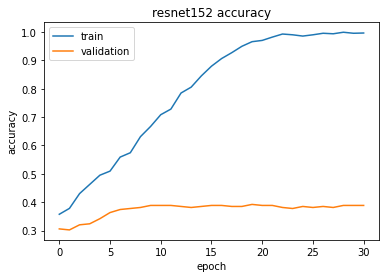

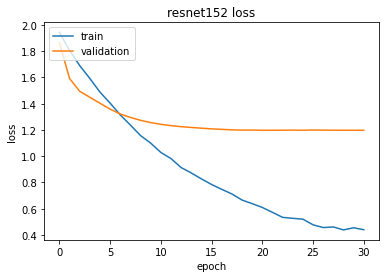

9/9 [==============================] - 4s 164ms/step
[[ 8 41 39]
 [ 8 60 39]
 [12 31 40]]
Acuracia balanceada na validacao: 0.3778614884346221


In [ ]:
cria_e_treina_rede('resnet152', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 24s 367ms/step - loss: 1.4658 - acc: 0.3177 - val_loss: 1.2232 - val_acc: 0.3741
Epoch 2/500
35/35 [==============================] - 10s 299ms/step - loss: 1.4518 - acc: 0.3321 - val_loss: 1.1757 - val_acc: 0.3741
Epoch 3/500
35/35 [============================

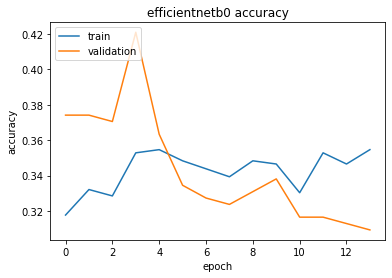

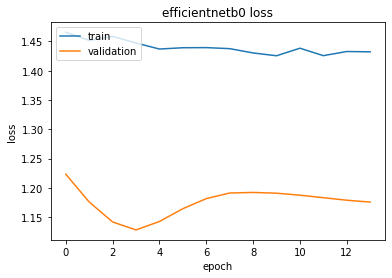

9/9 [==============================] - 2s 69ms/step
[[44 44  0]
 [35 72  0]
 [37 45  1]]
Acuracia balanceada na validacao: 0.3949817963442555


In [ ]:
cria_e_treina_rede('efficientnetb0', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
27025408/27018416 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843      
Total params: 6,579,082
Trainable params: 6,517,027
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 33s 501ms/step - loss: 1.4410 - acc: 0.3474 - val_loss: 1.2401 - val_acc: 0.3022
Epoch 2/500
35/35 [==============================] - 15s 425ms/step - loss: 1.4332 - acc: 0.3618 - val_loss: 1.1921 - val_acc: 0.3129
Epoch 3/500
35/35 [============================

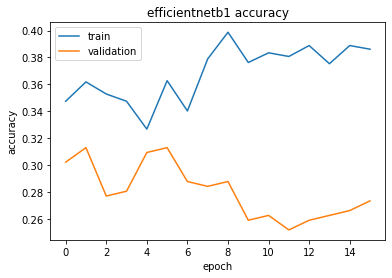

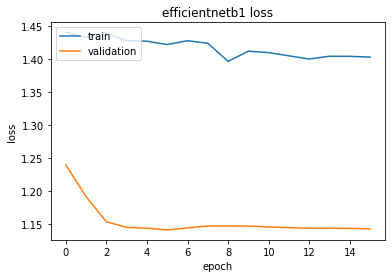

9/9 [==============================] - 3s 75ms/step
[[29 28 31]
 [43 26 38]
 [28 23 32]]
Acuracia balanceada na validacao: 0.31935942580858695


In [ ]:
cria_e_treina_rede('efficientnetb1', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
31793152/31790344 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 4227      
Total params: 7,772,796
Trainable params: 7,705,221
Non-trainable params: 67,575
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 33s 528ms/step - loss: 1.4429 - acc: 0.3033 - val_loss: 1.1124 - val_acc: 0.3381
Epoch 2/500
35/35 [==============================] - 15s 438ms/step - loss: 1.4439 - acc: 0.3006 - val_loss: 1.1020 - val_acc: 0.3237
Epoch 3/500
35/35 [============================

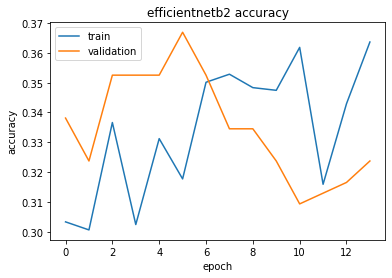

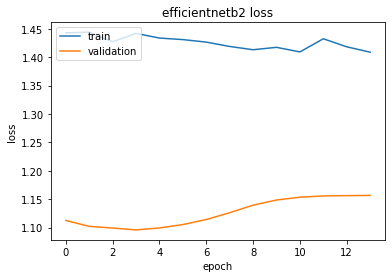

9/9 [==============================] - 3s 75ms/step
[[29 18 41]
 [22 29 56]
 [18 25 40]]
Acuracia balanceada na validacao: 0.36083373425733517


In [ ]:
cria_e_treina_rede('efficientnetb2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
43941888/43941136 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 4611      
Total params: 10,788,146
Trainable params: 10,700,843
Non-trainable params: 87,303
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 40s 641ms/step - loss: 1.4564 - acc: 0.3339 - val_loss: 1.2030 - val_acc: 0.2986
Epoch 2/500
35/35 [==============================] - 18s 530ms/step - loss: 1.4592 - acc: 0.3177 - val_loss: 1.1613 - val_acc: 0.3309
Epoch 3/500
35/35 [==========================

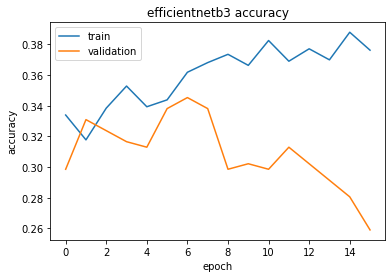

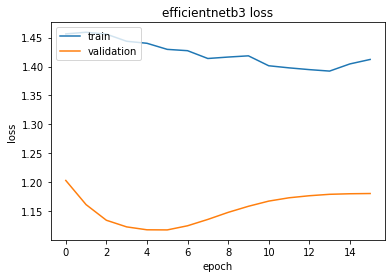

9/9 [==============================] - 3s 80ms/step
[[32 18 38]
 [28 32 47]
 [26 27 30]]
Acuracia balanceada na validacao: 0.3413825224432138


In [ ]:
cria_e_treina_rede('efficientnetb3', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
71688192/71686520 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 5379      
Total params: 17,679,202
Trainable params: 17,553,995
Non-trainable params: 125,207
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 49s 788ms/step - loss: 1.4566 - acc: 0.3114 - val_loss: 1.1126 - val_acc: 0.3273
Epoch 2/500
35/35 [==============================] - 23s 663ms/step - loss: 1.4647 - acc: 0.2997 - val_loss: 1.1164 - val_acc: 0.3237
Epoch 3/500
35/35 [=========================

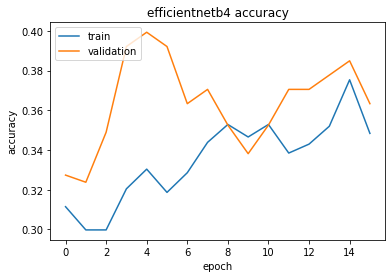

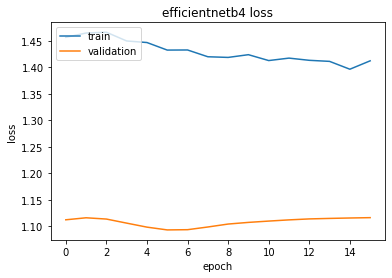

9/9 [==============================] - 4s 106ms/step
[[26 48 14]
 [26 67 14]
 [20 47 16]]
Acuracia balanceada na validacao: 0.37146461803032005


In [ ]:
cria_e_treina_rede('efficientnetb4', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
115269632/115263384 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 6147      
Total params: 28,519,674
Trainable params: 28,346,931
Non-trainable params: 172,743
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 67s 569ms/step - loss: 1.4394 - acc: 0.3114 - val_loss: 1.1001 - val_acc: 0.3381
Epoch 2/500
70/70 [==============================] - 35s 500ms/step - loss: 1.4387 - acc: 0.3249 - val_loss: 1.1016 - val_acc: 0.3273
Epoch 3/500
70/70 [=======================

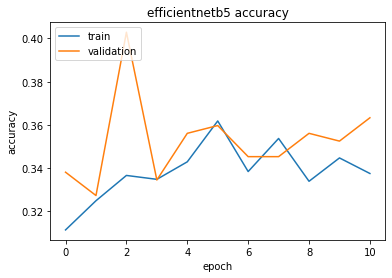

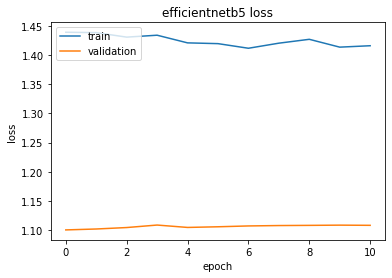

18/18 [==============================] - 5s 80ms/step
[[19 45 24]
 [12 48 47]
 [15 41 27]]
Acuracia balanceada na validacao: 0.32993614218982986


In [ ]:
cria_e_treina_rede('efficientnetb5', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
165240832/165234480 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 2304)              40960143  
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 6915      
Total params: 40,967,058
Trainable params: 40,742,619
Non-trainable params: 224,439
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 80s 694ms/step - loss: 1.4328 - acc: 0.3384 - val_loss: 1.1109 - val_acc: 0.3597
Epoch 2/500
70/70 [==============================] - 43s 611ms/step - loss: 1.4296 - acc: 0.3420 - val_loss: 1.1195 - val_acc: 0.3453
Epoch 3/500
70/70 [=======================

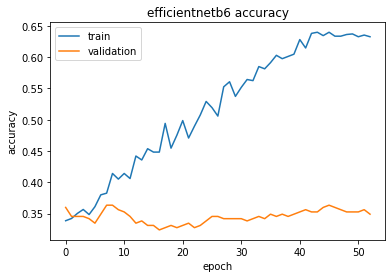

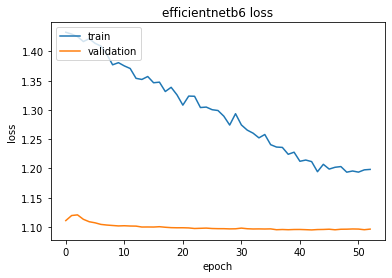

18/18 [==============================] - 6s 102ms/step
[[31 30 27]
 [38 37 32]
 [27 26 30]]
Acuracia balanceada na validacao: 0.353170967642874


In [ ]:
cria_e_treina_rede('efficientnetb6', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
258080768/258076736 [==============================] - 2s 0us/step
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2560)              64097687  
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 7683      
Total params: 64,105,370
Trainable params: 63,794,643
Non-trainable params: 310,727
_________________________________________________________________
Epoch 1/500
139/139 [==============================] - 111s 530ms/step - loss: 1.4336 - acc: 0.3402 - val_loss: 1.1241 - val_acc: 0.2950
Epoch 2/500
139/139 [==============================] - 65s 466ms/step - loss: 1.4222 - acc: 0.3339 - val_loss: 1.1249 - val_acc: 0.3129
Epoch 3/500
139/139 [===============

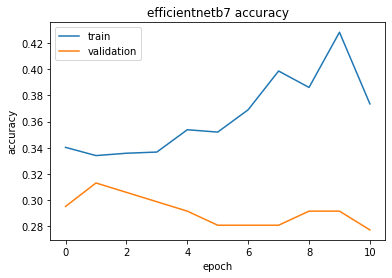

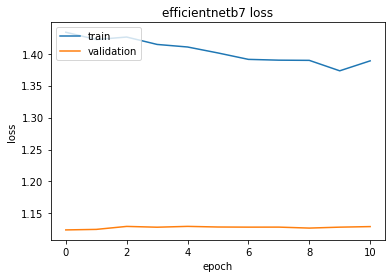

35/35 [==============================] - 8s 79ms/step
[[13 35 40]
 [19 32 56]
 [17 29 37]]
Acuracia balanceada na validacao: 0.2975252752727136


In [ ]:
cria_e_treina_rede('efficientnetb7', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=8)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 11s 239ms/step - loss: 1.6196 - acc: 0.3321 - val_loss: 1.5175 - val_acc: 0.3129
Epoch 2/500
35/35 [==============================] - 7s 212ms/step - loss: 1.6065 - acc: 0.3402 - val_loss: 1.4348 - val_acc: 0.3165
Epoch 3/500
35/35 [============================

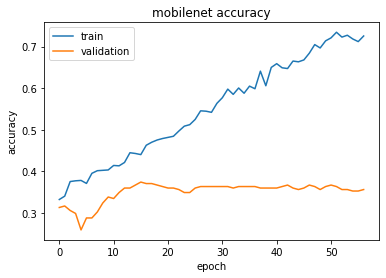

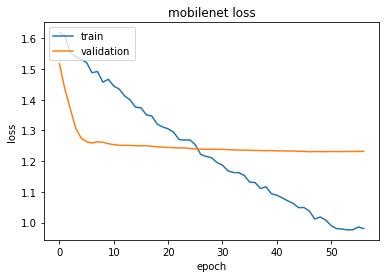

9/9 [==============================] - 1s 74ms/step
[[31 36 21]
 [30 41 36]
 [28 25 30]]
Acuracia balanceada na validacao: 0.36563202683290513


In [ ]:
cria_e_treina_rede('mobilenet', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 14s 264ms/step - loss: 1.6630 - acc: 0.2862 - val_loss: 1.6581 - val_acc: 0.3345
Epoch 2/500
35/35 [==============================] - 8s 222ms/step - loss: 1.6438 - acc: 0.2934 - val_loss: 1.6218 - val_acc: 0.3381
Epoch 3/500
35/35 [==============================

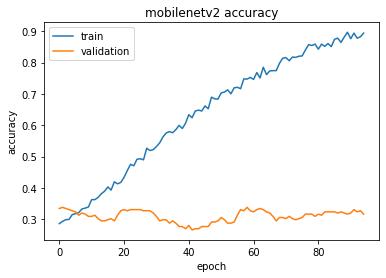

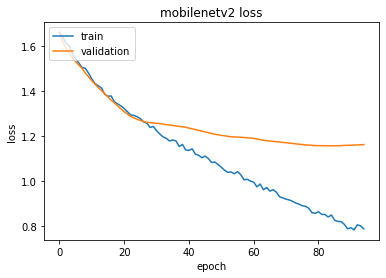

9/9 [==============================] - 2s 76ms/step
[[35 20 33]
 [30 32 45]
 [38 22 23]]
Acuracia balanceada na validacao: 0.32463370900765337


In [ ]:
cria_e_treina_rede('mobilenetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 27s 381ms/step - loss: 1.7755 - acc: 0.2997 - val_loss: 1.4388 - val_acc: 0.2986
Epoch 2/500
35/35 [==============================] - 9s 261ms/step - loss: 1.7320 - acc: 0.3096 - val_loss: 1.5023 - val_acc: 0.3094
Epoch 3/500
35/35 [============================

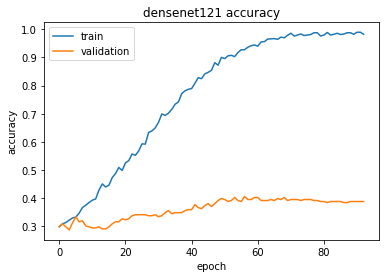

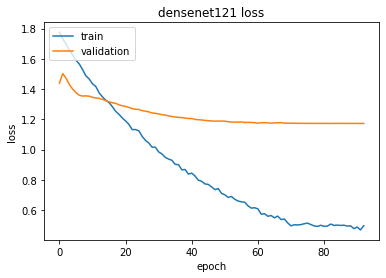

9/9 [==============================] - 3s 88ms/step
[[38 25 25]
 [35 43 29]
 [29 27 27]]
Acuracia balanceada na validacao: 0.3863295151719879


In [ ]:
cria_e_treina_rede('densenet121', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
51879936/51877672 [==============================] - 0s 0us/step
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 12,489,475
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 34s 438ms/step - loss: 1.7246 - acc: 0.2952 - val_loss: 1.2468 - val_acc: 0.3381
Epoch 2/500
35/35 [==============================] - 11s 310ms/step - loss: 1.6781 - acc: 0.3222 - val_loss: 1.3216 - val_acc: 0.3417
Epoch 3/500
35/35 [========================

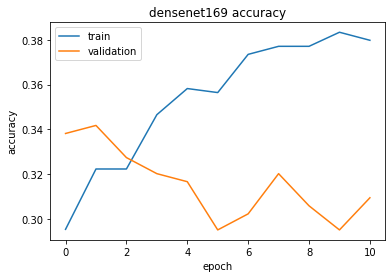

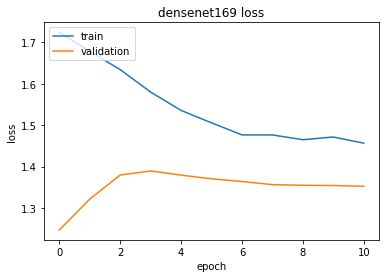

9/9 [==============================] - 4s 95ms/step
[[62  7 19]
 [73 10 24]
 [56  5 22]]
Acuracia balanceada na validacao: 0.3543545464781812


In [ ]:
cria_e_treina_rede('densenet169', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 18,098,691
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 47s 322ms/step - loss: 1.6140 - acc: 0.3987 - val_loss: 1.1839 - val_acc: 0.3022
Epoch 2/500
70/70 [==============================] - 16s 231ms/step - loss: 1.5380 - acc: 0.4230 - val_loss: 1.1665 - val_acc: 0.3345
Epoch 3/500
70/70 [========================

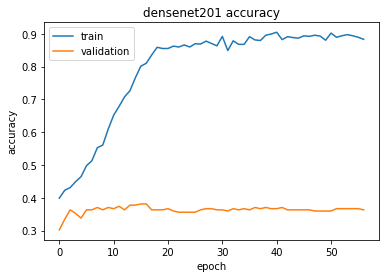

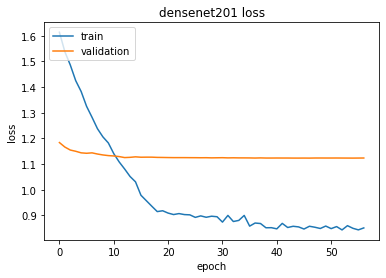

18/18 [==============================] - 5s 60ms/step
[[25 38 25]
 [32 53 22]
 [25 35 23]]
Acuracia balanceada na validacao: 0.3521754818765291


In [ ]:
cria_e_treina_rede('densenet201', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 20s 159ms/step - loss: 1.4778 - acc: 0.3366 - val_loss: 1.2756 - val_acc: 0.3094
Epoch 2/500
70/70 [==============================] - 9s 122ms/step - loss: 1.4581 - acc: 0.3348 - val_loss: 1.1567 - val_acc: 0.3597
Epoch 3/500
70/70 [==========================

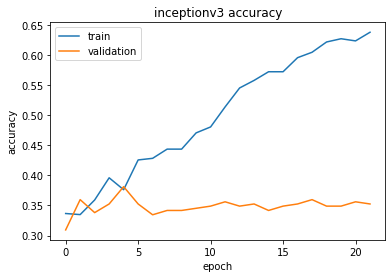

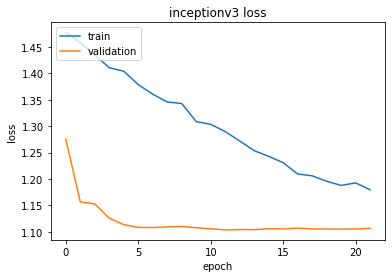

18/18 [==============================] - 2s 44ms/step
[[41 29 18]
 [47 32 28]
 [32 25 26]]
Acuracia balanceada na validacao: 0.3594091745060104


In [ ]:
cria_e_treina_rede('inceptionv3', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 44s 614ms/step - loss: 1.4260 - acc: 0.3213 - val_loss: 1.1617 - val_acc: 0.3201
Epoch 2/500
35/35 [==============================] - 16s 453ms/step - loss: 1.4022 - acc: 0.3303 - val_loss: 1.1465 - val_acc: 0.3633
Epoch 3/500
35/35 [=======================

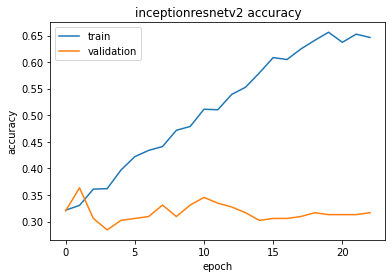

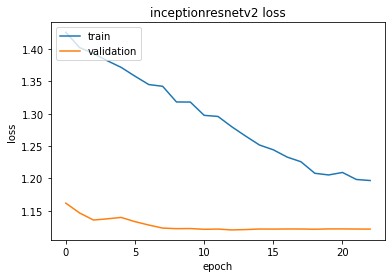

9/9 [==============================] - 5s 126ms/step
[[18 28 42]
 [19 33 55]
 [19 24 40]]
Acuracia balanceada na validacao: 0.3316281267806997


In [ ]:
cria_e_treina_rede('inceptionresnetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 26s 583ms/step - loss: 1.4208 - acc: 0.3591 - val_loss: 1.1248 - val_acc: 0.3237
Epoch 2/500
35/35 [==============================] - 18s 522ms/step - loss: 1.4109 - acc: 0.3807 - val_loss: 1.1251 - val_acc: 0.3273
Epoch 3/500
35/35 [=========================

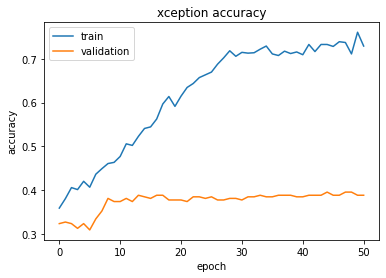

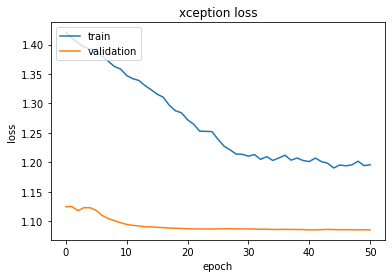

9/9 [==============================] - 2s 92ms/step
[[40 29 19]
 [36 49 22]
 [36 29 18]]
Acuracia balanceada na validacao: 0.37645228321953916


In [ ]:
cria_e_treina_rede('xception', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 16s 184ms/step - loss: 3.0507 - acc: 0.3222 - val_loss: 1.6453 - val_acc: 0.3309
Epoch 2/500
70/70 [==============================] - 10s 146ms/step - loss: 1.8611 - acc: 0.3501 - val_loss: 1.4130 - val_acc: 0.3201
Epoch 3/500
70/70 [==============================

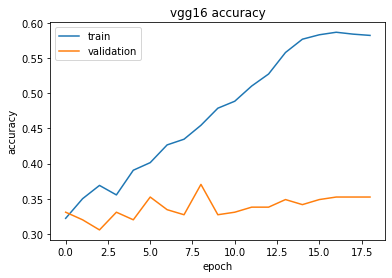

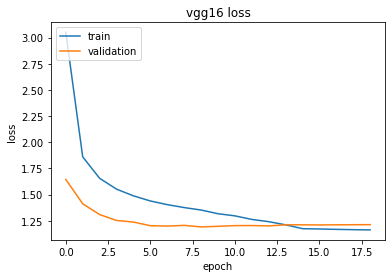

18/18 [==============================] - 1s 46ms/step
[[20 34 34]
 [25 54 28]
 [17 37 29]]
Acuracia balanceada na validacao: 0.3604477382768116


In [ ]:
cria_e_treina_rede('vgg16', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 17s 175ms/step - loss: 3.2667 - acc: 0.3249 - val_loss: 1.4499 - val_acc: 0.3669
Epoch 2/500
70/70 [==============================] - 12s 170ms/step - loss: 1.7259 - acc: 0.3285 - val_loss: 1.3087 - val_acc: 0.3561
Epoch 3/500
70/70 [==============================

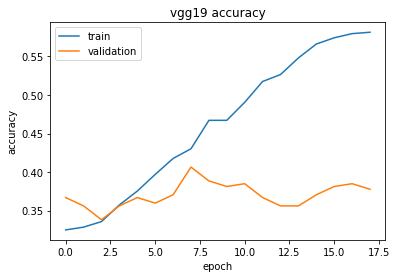

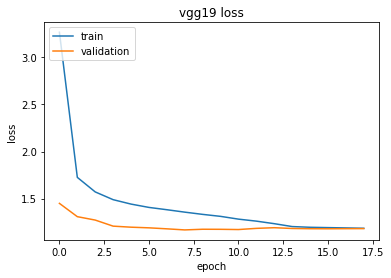

18/18 [==============================] - 1s 47ms/step
[[38 34 16]
 [27 54 26]
 [33 29 21]]
Acuracia balanceada na validacao: 0.39650104240240486


In [ ]:
cria_e_treina_rede('vgg19', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)